/tmp/ipykernel_119254/2485320300.py:279: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


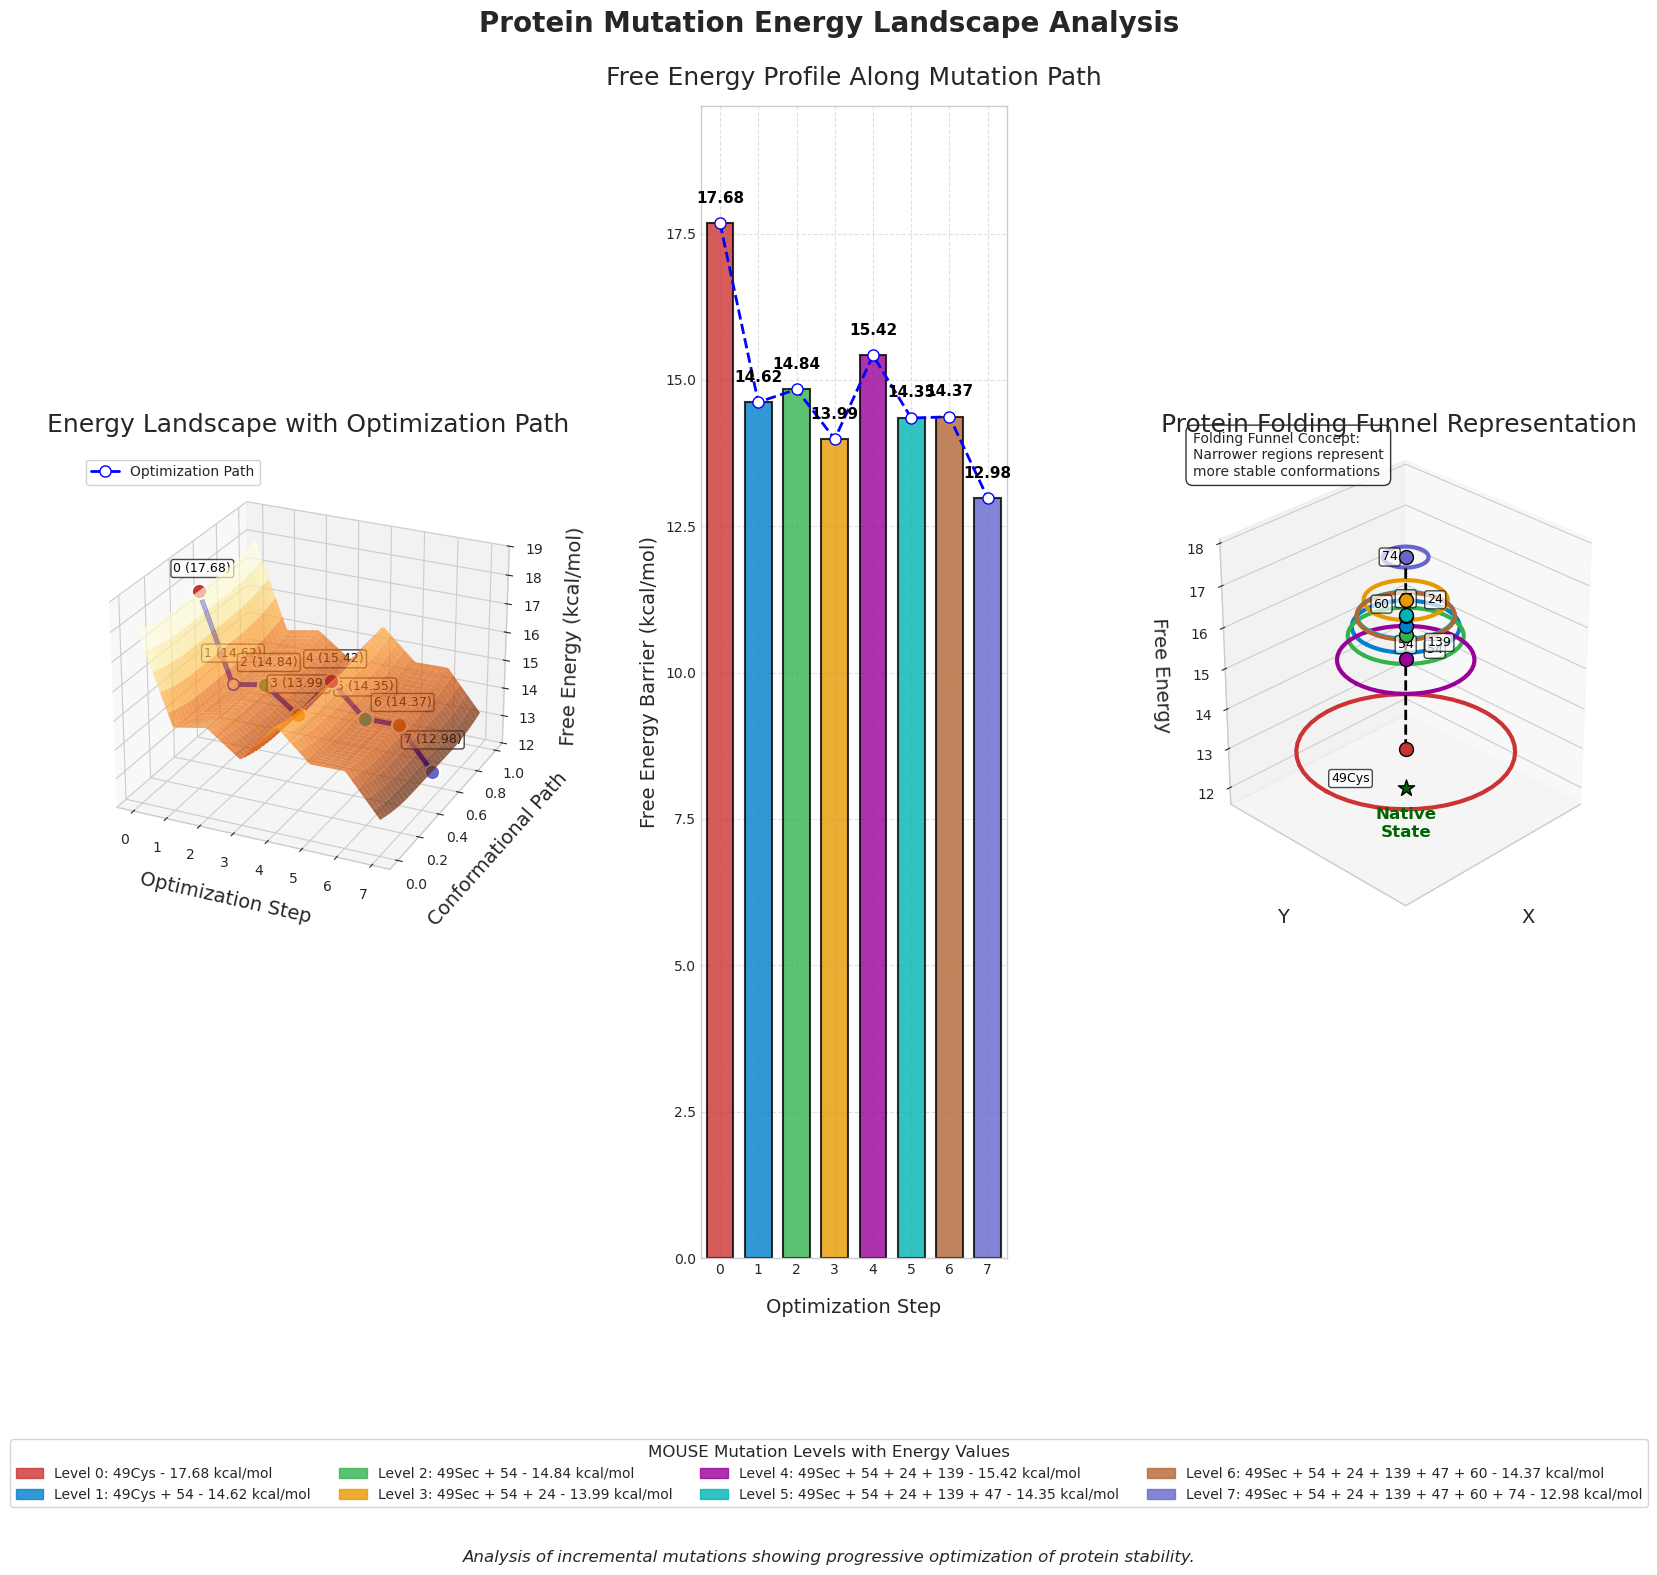

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.ticker as ticker
from matplotlib.patches import Polygon
from matplotlib import rcParams

# Improve overall style and fonts
plt.style.use('seaborn-v0_8-whitegrid')
rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.size'] = 12
rcParams['axes.labelsize'] = 14
rcParams['axes.titlesize'] = 16
rcParams['legend.fontsize'] = 11
rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10

# Data
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98])
mutations = [
    "49Cys",
    "49Cys + 54",
    "49Sec + 54",
    "49Sec + 54 + 24",
    "49Sec + 54 + 24 + 139",
    "49Sec + 54 + 24 + 139 + 47",
    "49Sec + 54 + 24 + 139 + 47 + 60",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74"
]

# Updated mutation progression with clearer labels and energy values
mutation_progression = [
    f"Level 0: 49Cys - {barriers[0]:.2f} kcal/mol",
    f"Level 1: 49Cys + 54 - {barriers[1]:.2f} kcal/mol",
    f"Level 2: 49Sec + 54 - {barriers[2]:.2f} kcal/mol",
    f"Level 3: 49Sec + 54 + 24 - {barriers[3]:.2f} kcal/mol",
    f"Level 4: 49Sec + 54 + 24 + 139 - {barriers[4]:.2f} kcal/mol",
    f"Level 5: 49Sec + 54 + 24 + 139 + 47 - {barriers[5]:.2f} kcal/mol",
    f"Level 6: 49Sec + 54 + 24 + 139 + 47 + 60 - {barriers[6]:.2f} kcal/mol",
    f"Level 7: 49Sec + 54 + 24 + 139 + 47 + 60 + 74 - {barriers[7]:.2f} kcal/mol"
]

# More distinguishable colormap to avoid similar colors
colors_custom = [
    (0.8, 0.2, 0.2),  # Red for level 0
    (0.0, 0.5, 0.8),  # Blue for level 1
    (0.2, 0.7, 0.3),  # Green for level 2
    (0.9, 0.6, 0.0),  # Orange for level 3
    (0.6, 0.0, 0.6),  # Purple for level 4
    (0.0, 0.7, 0.7),  # Teal for level 5
    (0.7, 0.4, 0.2),  # Brown for level 6
    (0.4, 0.4, 0.8)   # Lavender for level 7
]
custom_cmap = LinearSegmentedColormap.from_list("custom", colors_custom, N=len(levels))

# Create figure with adjusted layout - make the 3D plots larger
fig = plt.figure(figsize=(20, 16))  # Increased height for more space
grid = plt.GridSpec(1, 3, width_ratios=[1.5, 1, 1.5], wspace=0.4)

# Create smooth surface function for 3D plot
def create_smooth_surface(levels, barriers):
    x = np.linspace(0, 7, 100)
    y = np.linspace(0, 1, 100)
    X, Y = np.meshgrid(x, y)
    
    Z = np.zeros_like(X)
    for i in range(len(X)):
        for j in range(len(X[0])):
            xval = X[i][j]
            if xval <= levels[0]:
                Z[i][j] = barriers[0]
            elif xval >= levels[-1]:
                Z[i][j] = barriers[-1]
            else:
                idx = np.searchsorted(levels, xval)
                t = (xval - levels[idx-1]) / (levels[idx] - levels[idx-1])
                Z[i][j] = barriers[idx-1] + t * (barriers[idx] - barriers[idx-1])
            
            center_y = 0.5
            dist_from_center = abs(Y[i][j] - center_y)
            if dist_from_center < 0.2:
                variance = 0
            else:
                variance = 3 * (dist_from_center - 0.2)**2
                
            Z[i][j] += variance
            
    return X, Y, Z

X_smooth, Y_smooth, Z_smooth = create_smooth_surface(levels, barriers)

# --- 3D Surface with Path --- 
ax1 = fig.add_subplot(grid[0], projection='3d')

# Plot the smooth surface
surf = ax1.plot_surface(X_smooth, Y_smooth, Z_smooth, 
                        cmap='YlOrBr_r',
                        alpha=0.7, 
                        edgecolor='none',
                        rstride=3, cstride=3,
                        linewidth=0.2, 
                        antialiased=True,
                        shade=True)

# Plot a highlighted path on the surface
path_y = np.ones(len(levels)) * 0.5
ax1.plot(levels, path_y, barriers, color='blue', linewidth=3.5, 
         marker='o', markersize=8, markerfacecolor='white', markeredgecolor='blue', 
         label="Optimization Path")

# Enhanced scatter points for each mutation with careful text placement
for i in range(len(levels)):
    ax1.scatter(levels[i], 0.5, barriers[i], color=colors_custom[i], s=120, 
                edgecolor='white', linewidth=1.5)
    
    # Position text labels to avoid overlaps
    z_offset = 0.5 if i % 2 == 0 else 0.8
    x_offset = 0.05 if i % 2 == 0 else -0.05
    
    # Add level number to each point
    level_label = f"{levels[i]} ({barriers[i]:.2f})"
    ax1.text(levels[i] + x_offset, 0.52, barriers[i] + z_offset, 
            level_label,
            color='black', fontsize=9, ha='center', va='bottom',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

ax1.set_xlabel("Optimization Step", fontsize=14, labelpad=10)
ax1.set_ylabel("Conformational Path", fontsize=14, labelpad=10)
ax1.set_zlabel("Free Energy (kcal/mol)", fontsize=14, labelpad=10)
ax1.set_title("Energy Landscape with Optimization Path", fontsize=18, pad=15)
ax1.view_init(elev=25, azim=-65)

# Add a grid for better depth perception
ax1.grid(True, linestyle='--', alpha=0.6)

# Improve axis aesthetics
ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax1.set_zlim(12, 19)

# Add a compact legend that doesn't overlap
legend_elements = [plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', 
                              markerfacecolor='white', markeredgecolor='blue',
                              markersize=8, linewidth=2, label="Optimization Path")]

ax1.legend(handles=legend_elements, loc='upper left', 
          fontsize=10, frameon=True, framealpha=0.9)

# --- Simplified Bar Plot with clear labels ---
ax2 = fig.add_subplot(grid[1])

# Create gradient bars with consistent colors
for i, (lvl, val) in enumerate(zip(levels, barriers)):
    # Use consistent colors from the custom color map
    bar_color = colors_custom[i]
    
    # Create solid color bar with alpha gradient
    ax2.bar(lvl, val, width=0.7, color=bar_color, 
            edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value label on top in black
    ax2.text(lvl, val + 0.3, f"{val:.2f}", 
            ha='center', va='bottom', fontsize=11, fontweight='bold', color='black')

# Add connecting line showing the trend
ax2.plot(levels, barriers, 'o--', color='blue', markersize=8, 
        linewidth=2, markerfacecolor='white', markeredgecolor='blue',
        label="Energy Trend")

ax2.set_title("Free Energy Profile Along Mutation Path", fontsize=18, pad=15)
ax2.set_xlabel("Optimization Step", fontsize=14, labelpad=15)
ax2.set_ylabel("Free Energy Barrier (kcal/mol)", fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xticks(levels)
ax2.set_ylim(0, max(barriers) + 2)
ax2.set_xlim(-0.5, max(levels) + 0.5)

# Clean up x-axis labels to just show the step numbers
ax2.set_xticklabels([f"{i}" for i in range(8)])

# --- IMPROVED Folding Funnel Plot with better label spacing ---
ax3 = fig.add_subplot(grid[2], projection='3d')

# Create a clearer funnel
max_radius = 4
theta = np.linspace(0, 2 * np.pi, 50)
z_levels = barriers.copy()

# Normalize energy to better show as funnel depth
z_min = min(z_levels)
z_max = max(z_levels)
z_funnel = [z_max - (z - z_min) for z in z_levels]  # Invert for funnel representation

# Create a clearer funnel visualization with staggered labels
for i in range(len(levels)):
    # Make radius proportional to energy (higher energy = wider funnel)
    r = max_radius * (1 - (z_max - z_levels[i])/(z_max - z_min) * 0.8)
    
    # Draw the contour at this energy level
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    z = z_funnel[i] * np.ones_like(theta)
    
    # Use a consistent color scheme based on the level
    ax3.plot(x, y, z, color=colors_custom[i], linewidth=3)
    
    # Add marker at the central point of each level
    ax3.scatter(0, 0, z_funnel[i], color=colors_custom[i], s=100, 
               edgecolor='black', linewidth=1)
    
    # Calculate label positions at different angles to avoid overlaps
    angle = (i % 8) * (np.pi/4)  # Stagger around the circle
    label_x = r * 0.7 * np.cos(angle)
    label_y = r * 0.7 * np.sin(angle)
    
    # Create label with level number
    if i == 0:
        label = f"49Cys"
    else:
        latest_mutation = mutations[i].split(' + ')[-1]
        label = latest_mutation
    
    # Add the level number to the label with energy value
    full_label = f"{label}"
    
    # Position labels using calculated angles to avoid overlaps
    ax3.text(label_x, label_y, z_funnel[i], full_label, 
            color='black', fontsize=9, ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

# Connect the central points to show the descent path
central_x = np.zeros(len(levels))
central_y = np.zeros(len(levels))
ax3.plot(central_x, central_y, z_funnel, 'k--', linewidth=2, label="Folding Path")

# Add native state at bottom
native_z = min(z_funnel) - 1
ax3.scatter(0, 0, native_z, color='darkgreen', s=150, marker='*', 
           edgecolor='black', linewidth=1)
ax3.text(0, 0, native_z - 0.5, "Native\nState", 
        color='darkgreen', fontsize=12, fontweight='bold', ha='center', va='top')

# Simplify the axis labels
ax3.set_title("Protein Folding Funnel Representation", fontsize=18, pad=15)
ax3.set_xlabel("X", fontsize=14, labelpad=10)
ax3.set_ylabel("Y", fontsize=14, labelpad=10)
ax3.set_zlabel("Free Energy", fontsize=14, labelpad=10)
ax3.view_init(elev=30, azim=45)

# Set equal aspect ratio for better visualization
ax3.set_box_aspect([1,1,1.2])

# Add a clear explanation of the funnel concept
ax3.text2D(0.05, 0.95, "Folding Funnel Concept:\nNarrower regions represent\nmore stable conformations", 
          transform=ax3.transAxes, fontsize=10,
          bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Remove axis ticks for cleaner look
ax3.set_xticks([])
ax3.set_yticks([])

# Main title for the entire figure
fig.suptitle("Protein Mutation Energy Landscape Analysis", fontsize=20, fontweight='bold', y=0.98)

# Create a comprehensive legend showing all mutation levels with color codes
legend_handles = [plt.Rectangle((0,0),1,1, color=colors_custom[i], alpha=0.8) for i in range(len(levels))]
fig.legend(handles=legend_handles, labels=mutation_progression,
          loc='lower center', bbox_to_anchor=(0.5, 0.04),
          ncol=4, fontsize=10, frameon=True,
          title="MOUSE Mutation Levels with Energy Values", title_fontsize=12)

# Add footer text
footer_text = "Analysis of incremental mutations showing progressive optimization of protein stability."
fig.text(0.5, 0.01, footer_text, ha='center', fontsize=12, style='italic')

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.2)  # More space for the bottom legend
plt.savefig('improved_energy_landscape.png', dpi=300, bbox_inches='tight')
plt.show()

All figures saved to 'figures' directory


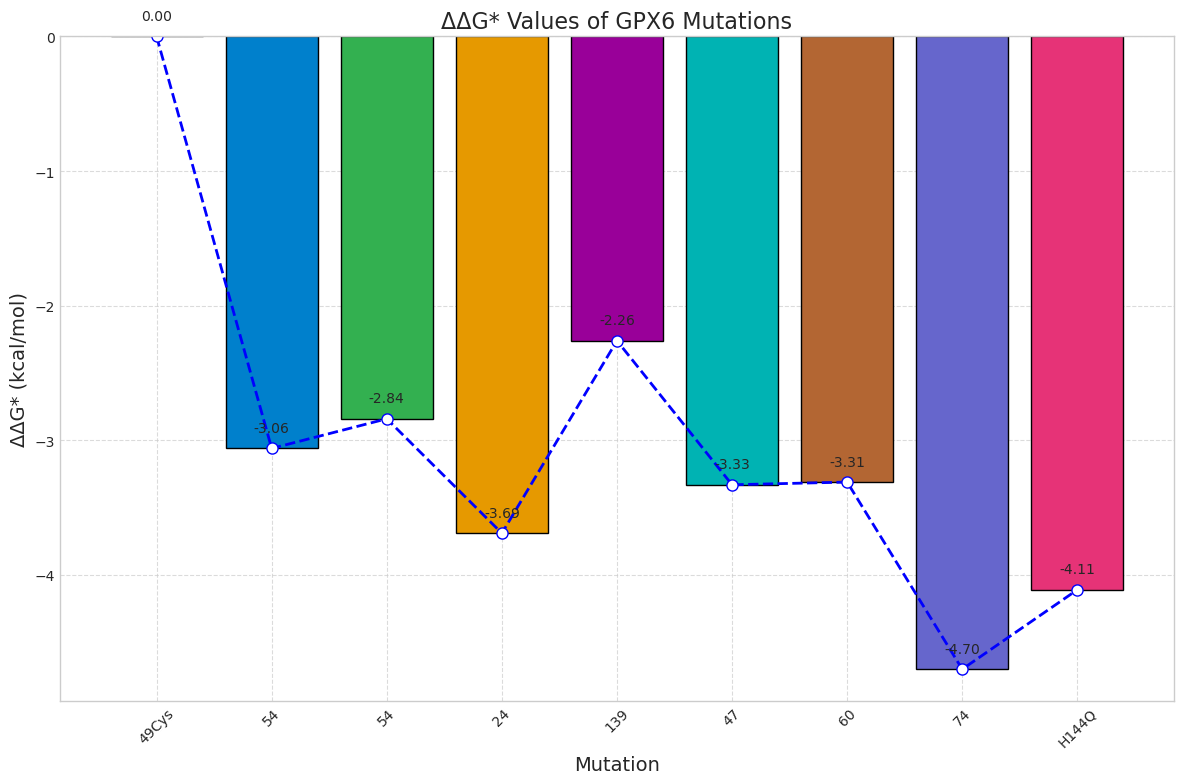

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Create a directory for saving figures
save_path = "figures"
os.makedirs(save_path, exist_ok=True)

# Data for GPX6 mutations
levels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
barriers = np.array([17.68, 14.62, 14.84, 13.99, 15.42, 14.35, 14.37, 12.98, 13.57])
ddg_values = barriers - barriers[0]

mutations = [
    "49Cys",
    "49Cys + 54",
    "49Sec + 54",
    "49Sec + 54 + 24",
    "49Sec + 54 + 24 + 139",
    "49Sec + 54 + 24 + 139 + 47",
    "49Sec + 54 + 24 + 139 + 47 + 60",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74",
    "49Sec + 54 + 24 + 139 + 47 + 60 + 74 + H144Q"
]

# Generate simple mutation labels (just the last part)
simple_labels = []
for i, mutation in enumerate(mutations):
    if i == 0:
        simple_labels.append("49Cys")
    else:
        parts = mutation.split(' + ')
        simple_labels.append(parts[-1])

# Colors for each level
colors = ['#CC3333', '#0080CC', '#33B050', '#E69900', '#990099', '#00B3B3', '#B36633', '#6666CC', '#E63377']

# 1. SIMPLE LINE PLOT (Energy Profile)
plt.figure(figsize=(12, 8))
plt.plot(levels, barriers, 'o-', color='blue', linewidth=2, markersize=10)

# Add value labels
for i, (lvl, val) in enumerate(zip(levels, barriers)):
    plt.text(lvl, val + 0.3, f"{val:.2f}", ha='center', fontsize=10)

# Add mutation labels below x-axis
plt.xticks(levels, simple_labels, rotation=45)

plt.title("GPX6 Energy Profile", fontsize=16)
plt.xlabel("Mutation", fontsize=14)
plt.ylabel("Energy Barrier (kcal/mol)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(save_path, "gpx6_energy_profile.png"), dpi=300)
plt.close()

# 2. BAR PLOT (simpler version)
plt.figure(figsize=(12, 8))

# Create bars
bars = plt.bar(levels, barriers, color=colors, edgecolor='black', linewidth=1)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f"{barriers[i]:.2f}", ha='center', va='bottom', fontsize=10)

# Add connecting line
plt.plot(levels, barriers, 'o--', color='blue', linewidth=2, markersize=8, 
        markerfacecolor='white', markeredgecolor='blue')

# Add mutation labels below x-axis
plt.xticks(levels, simple_labels, rotation=45)

plt.title("Free Energy Profile of GPX6 Mutations", fontsize=16)
plt.xlabel("Mutation", fontsize=14)
plt.ylabel("Free Energy Barrier (kcal/mol)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(save_path, "gpx6_energy_barplot.png"), dpi=300)
plt.close()

# 3. DELTA-DELTA G PLOT
plt.figure(figsize=(12, 8))

# Create bars for ΔΔG* values
bars = plt.bar(levels, ddg_values, color=colors, edgecolor='black', linewidth=1)

# Add value labels on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f"{ddg_values[i]:.2f}", ha='center', va='bottom', fontsize=10)

# Add connecting line
plt.plot(levels, ddg_values, 'o--', color='blue', linewidth=2, markersize=8, 
        markerfacecolor='white', markeredgecolor='blue')

# Add mutation labels below x-axis
plt.xticks(levels, simple_labels, rotation=45)

plt.title("ΔΔG* Values of GPX6 Mutations", fontsize=16)
plt.xlabel("Mutation", fontsize=14)
plt.ylabel("ΔΔG* (kcal/mol)", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(save_path, "gpx6_ddg_values.png"), dpi=300)

print(f"All figures saved to '{save_path}' directory")